# Long Short-Term Memory Network

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.<br>

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.<br>

Instead of neurons, LSTM networks have memory blocks that are connected through layers.<br>

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.<br>

There are three types of gates within a unit:<br>

-**Forget Gate**: conditionally decides what information to throw away from the block.<br>
-**Input Gate**: conditionally decides which values from the input to update the memory state.<br>
-**Output Gate**: conditionally decides what to output based on input and the memory of the block.<br><br>
Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.<br>

## Imports

In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

## Data Import

In [24]:
from pandas_datareader import DataReader
from datetime import datetime

df = DataReader('ADBE',  'yahoo', datetime(2018,1,1), datetime(2021,1,1))

In [36]:
a = df.iloc[0:550]

In [38]:
a

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,177.800003,175.259995,175.850006,177.699997,2432800,177.699997
2018-01-03,181.889999,177.699997,178.000000,181.039993,2561200,181.039993
2018-01-04,184.059998,181.639999,181.929993,183.220001,2211400,183.220001
2018-01-05,185.899994,183.539993,185.000000,185.339996,2376500,185.339996
2018-01-08,185.600006,183.830002,184.949997,185.039993,2088000,185.039993
...,...,...,...,...,...,...
2020-03-04,364.269989,350.079987,354.380005,363.850006,4146300,363.850006
2020-03-05,360.450012,347.190002,355.059998,351.029999,3199000,351.029999
2020-03-06,344.160004,326.600006,340.450012,336.769989,5622900,336.769989


In [26]:
df1 = df["Adj Close"]

In [27]:
df1.shape

(756,)

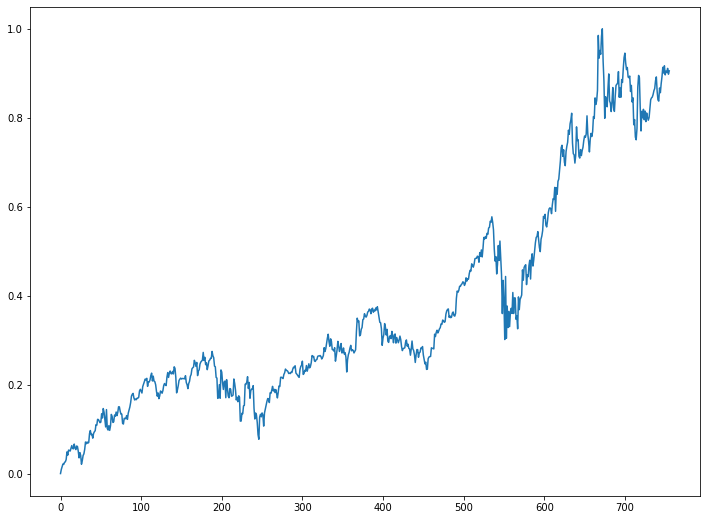

In [32]:
plt.figure(figsize=(12,9))
plt.plot(df1)

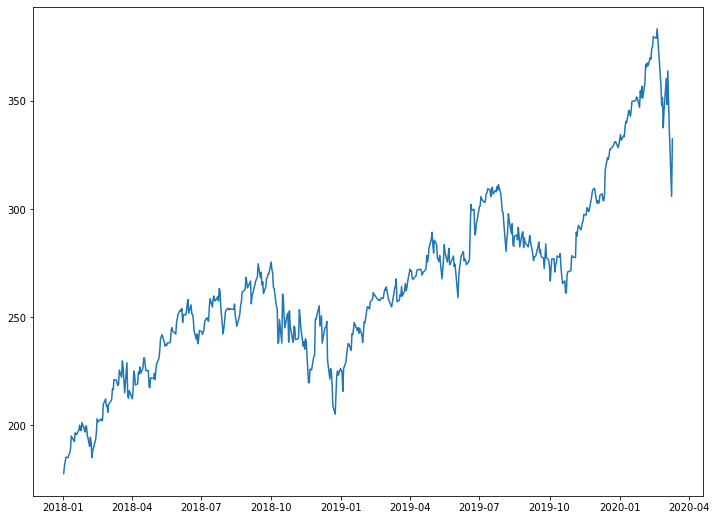

In [37]:
plt.figure(figsize=(12,9))
plt.plot(a['Adj Close'])

## Data Scaling

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
print(df1)

[[0.        ]
 [0.00937938]
 [0.01550128]
 [0.02145465]
 [0.02061218]
 [0.0252738 ]
 [0.02642517]
 [0.03150801]
 [0.04872229]
 [0.04144906]
 [0.0527661 ]
 [0.0519517 ]
 [0.05063184]
 [0.05655715]
 [0.0628756 ]
 [0.05638866]
 [0.05563044]
 [0.06627354]
 [0.05765234]
 [0.05391743]
 [0.06194889]
 [0.0608818 ]
 [0.05037912]
 [0.03529909]
 [0.04709353]
 [0.04111205]
 [0.02094919]
 [0.0288964 ]
 [0.04057848]
 [0.04431339]
 [0.05456335]
 [0.07096323]
 [0.06700365]
 [0.07099129]
 [0.068492  ]
 [0.06995227]
 [0.08997475]
 [0.09674248]
 [0.08739121]
 [0.08826175]
 [0.07955631]
 [0.09011513]
 [0.09396239]
 [0.09634934]
 [0.10996912]
 [0.10867733]
 [0.12190397]
 [0.12142658]
 [0.11811289]
 [0.11440608]
 [0.11561359]
 [0.13437239]
 [0.12490872]
 [0.14616682]
 [0.13802306]
 [0.12024715]
 [0.10480205]
 [0.14380794]
 [0.10137604]
 [0.09783768]
 [0.10777873]
 [0.09710756]
 [0.10735747]
 [0.13296829]
 [0.12872788]
 [0.11488347]
 [0.11645606]
 [0.13150801]
 [0.12898065]
 [0.13833196]
 [0.13018815]
 [0.13

## Train-Test Split

After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data. For a normal classification or regression problem, we would do this using cross validation.<br>

With time series data, the sequence of values is important. <br>

A simple method that we can use is to split the ordered dataset into train and test datasets. <br>

The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [30]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.67)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [31]:
len(train_data), len(test_data)

(506, 250)

## Lookback Function

Now we can define a function to create a new dataset, as described above.<br>

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.<br>

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).<br>

It can be configured, and we will by constructing a differently shaped dataset in the next section.<br>

In [11]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

Let’s use this function to prepare the train and test datasets for modeling.

In [12]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [13]:
print(X_train.shape), print(y_train.shape)


(390, 100)
(390,)


(None, None)

In [14]:
print(X_test.shape), print(ytest.shape)

(164, 100)
(164,)


(None, None)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].<br>

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:<br>

In [15]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [16]:
print(X_train.shape)
print(y_train.shape)

(390, 100, 1)
(390,)


## LSTM Model

In [17]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [18]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_train_function_7769]

Function call stack:
train_function -> train_function -> train_function


Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

In [51]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential_1/lstm_3/PartitionedCall]] [Op:__inference_predict_function_10637]

Function call stack:
predict_function -> predict_function -> predict_function


**We invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data**

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.<br>

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.<br>

In [52]:

### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

NameError: name 'train_predict' is not defined

## Adding Number of LSTM layers

The whole process is then repeated with added LSTM layers

In [53]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,177.800003,175.259995,175.850006,177.699997,2432800,177.699997
2018-01-03,181.889999,177.699997,178.000000,181.039993,2561200,181.039993
2018-01-04,184.059998,181.639999,181.929993,183.220001,2211400,183.220001
2018-01-05,185.899994,183.539993,185.000000,185.339996,2376500,185.339996
2018-01-08,185.600006,183.830002,184.949997,185.039993,2088000,185.039993
...,...,...,...,...,...,...
2020-12-24,503.010010,497.279999,499.160004,499.859985,589200,499.859985
2020-12-28,506.040009,496.820007,505.609985,498.950012,1515400,498.950012
2020-12-29,505.350006,499.739990,501.170013,502.109985,1434100,502.109985


In [54]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))

In [55]:
prediction_days = 30

In [56]:
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)  
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))

In [57]:
print(x_train.shape), print(y_train.shape)

(726, 30, 1)
(726,)


(None, None)

In [58]:
#Building the Model
model = Sequential()

model.add(LSTM(units=50, return_sequences= True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences= True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [59]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 50)            10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [62]:
model.fit(x_train, y_train, epochs=25, batch_size=32)


Epoch 1/25


UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential_2/lstm_6/PartitionedCall]] [Op:__inference_train_function_18510]

Function call stack:
train_function -> train_function -> train_function


In [192]:
#load test data
test_start = datetime(2021,1,2)
test_end = datetime(2021,4,2)

In [193]:
test_data = DataReader('ADBE',  'yahoo', test_start, test_end)

In [194]:
test_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-04,500.790009,476.279999,500.299988,485.339996,3612900,485.339996
2021-01-05,486.079987,479.200012,485.880005,485.690002,2010100,485.690002
2021-01-06,475.869995,466.000000,474.100006,466.309998,4156600,466.309998
2021-01-07,479.640015,468.250000,471.000000,477.739990,2901200,477.739990
2021-01-08,485.540009,477.209991,480.000000,485.100006,2266100,485.100006
...,...,...,...,...,...,...
2021-03-26,469.769989,449.049988,450.250000,469.089996,3614400,469.089996
2021-03-29,472.000000,462.500000,469.029999,469.320007,3141900,469.320007
2021-03-30,469.089996,461.500000,462.579987,465.459991,2436300,465.459991


In [195]:
actual_prices = test_data["Adj Close"].values

In [196]:
total_dataset = pd.concat((df["Adj Close"], test_data["Adj Close"]), axis=0)

In [197]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) -prediction_days:].values

In [198]:
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [199]:
# Make predictions on Test Data
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

In [200]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [201]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

In [202]:
#Plot the predictions

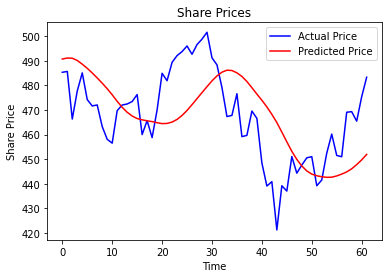

In [203]:
plt.plot(actual_prices, color= "blue", label = "Actual Price")
plt.plot(predicted_prices, color= "red", label = "Predicted Price")
plt.title("Share Prices")
plt.xlabel('Time')
plt.ylabel('Share Price')
plt.legend()
plt.show()

In [83]:
predicted_prices

array([[489.87515, 489.72717, 487.62976, ..., 489.4807 , 489.83017,
        489.1841 ],
       [490.36703, 490.0736 , 488.06824, ..., 489.9712 , 490.21936,
        489.73227],
       [490.7281 , 490.32162, 488.41708, ..., 490.36658, 490.47366,
        490.19308],
       ...,
       [488.3027 , 488.46   , 486.88144, ..., 488.95728, 487.51666,
        489.22153],
       [485.9507 , 486.74518, 485.0263 , ..., 487.03107, 485.14423,
        487.17758],
       [483.3614 , 484.87497, 482.9361 , ..., 484.78192, 482.6512 ,
        484.78128]], dtype=float32)